# 🧠 Hidden Markov Model (HMM) for Customer Journey Analysis

---

### 🔍 Situation

Customer journey data often includes observable behaviors—like browsing, email opens, and purchases—but the **underlying behavioral states** (e.g., _"Exploring"_ vs. _"Highly Engaged"_) remain hidden.

> Understanding these hidden states allows businesses to personalize marketing, predict churn, and increase conversions.

---

### 📌 Task

Build a **Hidden Markov Model (HMM)** to infer customer behavior states from observed actions.

> Segment users based on engagement and predict their likelihood of purchasing or becoming inactive.

---

### ✨ Action

#### ✅ **Created Synthetic Customer Journey Data**
- Simulated user interactions across five observable actions:
  - _Browsing_, _Email Engagement_, _App Engagement_, _Engaged Browsing_, _Purchase_
- Defined hidden behavioral states:
  - **Exploring**, **Engaged**, **Highly Engaged**, **Buyers**, **Dormant**
- Designed realistic **state transition** and **observation probabilities**

#### ✅ **Preprocessed Data for HMM**
- Encoded actions numerically
- Grouped and formatted sequences by user for compatibility with HMM

#### ✅ **Built & Trained the HMM**
- Used a **Multinomial Hidden Markov Model** with varying hidden states
- Trained on action sequences to learn transition patterns
- Predicted hidden state sequences per user

#### ✅ **Evaluated Model Performance**
- Compared models with 1–6 hidden states using:
  - **Log-Likelihood**
  - **AIC (Akaike Information Criterion)**
  - **BIC (Bayesian Information Criterion)**
- Chose the optimal number of states based on balance of fit and simplicity

---

### 📈 Result

- Users successfully segmented into **inferred engagement states**
- Key transition insights revealed:
  - e.g., _"Exploring" → "Engaged"_ or _"Engaged" → "Dormant"_
- Best model used **4 hidden states**, offering interpretability and performance
- Actionable insight:
  > Marketers can now target **"Highly Engaged"** users with timely offers to drive purchases

---

### 🚀 Next Steps

- **Enhance realism** with temporal patterns, seasonality, or demographic features  
- Explore **Hierarchical or Bayesian HMMs** for more flexible state modeling  
- **Forecast future behavior** using learned transition probabilities  
- **Deploy on real customer data** and validate conversion lift

---

### ✍ Author: Justin Wall  
### 📅 Updated: 2025-03-12

In [ ]:
# =============================================
# Create Fake Dataset for Customer Journey
# =============================================

import numpy as np
import pandas as pd
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Define dataset parameters
num_users = 500  # Number of users
max_days = 30  # Max tracking window for each user
dormancy_threshold = 7  # Days of inactivity before considering a user lost
purchase_ratio = 0.05  # Only 5% of users should end in purchase

# Define possible actions and their probabilities
actions = ["browse", "email_engagement", "app_engagement", "engaged_browse", "purchase"]
base_action_probs = [0.5, 0.15, 0.1, 0.2, 0.05]  # Adjusted to fit the scenario

# Generate user journeys
user_data = []
num_purchased = 0
num_dormant = 0

for user_id in range(1, num_users + 1):
    start_date = pd.to_datetime("2024-01-01") + pd.to_timedelta(np.random.randint(0, 10), unit='D')
    current_date = start_date
    last_action_date = start_date
    purchased = False
    
    while True:
        # Choose an action
        action = np.random.choice(actions, p=base_action_probs)
        user_data.append([user_id, current_date, action])
        
        # Stop tracking if purchase occurs (only allow 5% of users to purchase)
        if action == "purchase":
            if num_purchased / num_users < purchase_ratio:
                num_purchased += 1
                purchased = True
                break
            else:
                action = "engaged_browse"  # Prevent excess purchases
        
        last_action_date = current_date
        
        # Move to the next day
        current_date += pd.Timedelta(days=1)
        
        # Check dormancy condition
        if (current_date - last_action_date).days >= dormancy_threshold:
            num_dormant += 1
            break
        
        # Stop if we exceed max tracking window
        if (current_date - start_date).days > max_days:
            break

# Create DataFrame
df = pd.DataFrame(user_data, columns=["User ID", "Event Date", "Action"])

# Sort data
df = df.sort_values(by=["User ID", "Event Date"]).reset_index(drop=True)

# Display sample data
print("Sample of the generated dataset:")
print(df.head(10))
print("\nTotal users:", df['User ID'].nunique())
print("Total actions:", df['Action'].nunique())
print("Total event dates:", df['Event Date'].nunique())
df = df.sort_values(by=["User ID", "Event Date"])
last_action = df.groupby("User ID")["Action"].last().reset_index()
print(f"Final Actions: \n{last_action['Action'].value_counts()}")

# The dataset is now updated with the five observation types:
# Browse (quick website visit)
# Email Engagement (clicked an email)
# App Engagement (downloaded & used app)
# Engaged Browse (spent time or added to cart)
# Purchase (completed a transaction)

# Each user has a sequence of events tracked from their start date until they either:
# Make a purchase (outcome: "purchased")
# Become inactive for 7 days (outcome: "lost")
# Continue browsing beyond 30 days (rare but possible)

Sample of the generated dataset:
   User ID Event Date            Action
0        1 2024-01-07    engaged_browse
1        1 2024-01-08            browse
2        1 2024-01-09    engaged_browse
3        1 2024-01-10  email_engagement
4        1 2024-01-11            browse
5        1 2024-01-12            browse
6        1 2024-01-13            browse
7        1 2024-01-14            browse
8        1 2024-01-15            browse
9        1 2024-01-16    app_engagement

Total users: 500
Total actions: 5
Total event dates: 40
Final Actions: 
Action
browse              219
engaged_browse      100
email_engagement     79
app_engagement       52
purchase             50
Name: count, dtype: int64


In [18]:
# =============================================
# Build the HMM Model
# =============================================

# Encode categorical actions into numeric values
# order does not matter here!
label_encoder = LabelEncoder()
df["Action Encoded"] = label_encoder.fit_transform(df["Action"])
# Browse → 0
# Email Engagement → 1
# App Engagement → 2
# Engaged Browse → 3
# Purchase → 4

# Group sequences by User ID
user_sequences = df.groupby("User ID")["Action Encoded"].apply(list).values

# Convert sequences into a format usable by HMM
X = np.concatenate(user_sequences)  # Flatten the sequences
lengths = [len(seq) for seq in user_sequences]  # Track sequence lengths

# Define and train the Hidden Markov Model
num_hidden_states = 4  # Assume 4 hidden states for different customer behaviors
hmm_model = hmm.MultinomialHMM(n_components=num_hidden_states, n_iter=100, random_state=42)
hmm_model.fit(X.reshape(-1, 1), lengths)

# Predict hidden states for each sequence
hidden_states = [hmm_model.predict(np.array(seq).reshape(-1, 1)) for seq in user_sequences]

# Store hidden state predictions back into DataFrame
df["Hidden State"] = np.concatenate(hidden_states)

# Display a sample of the updated dataset with hidden states
print(f"\nSample of the dataset with hidden states: \n {df.head(10)}")
print(f"\nUnique Combinations: \n{df.groupby(['Action','Action Encoded','Hidden State']).size()}")

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



Sample of the dataset with hidden states: 
    User ID Event Date            Action  Action Encoded  Hidden State
0        1 2024-01-07    engaged_browse               3             1
1        1 2024-01-08            browse               1             2
2        1 2024-01-09    engaged_browse               3             2
3        1 2024-01-10  email_engagement               2             2
4        1 2024-01-11            browse               1             2
5        1 2024-01-12            browse               1             2
6        1 2024-01-13            browse               1             2
7        1 2024-01-14            browse               1             2
8        1 2024-01-15            browse               1             2
9        1 2024-01-16    app_engagement               0             2

Unique Combinations: 
Action            Action Encoded  Hidden State
app_engagement    0               1                 59
                                  2               1507
brows

In [ ]:
# =============================================
# Evaluate the HMM Model
# =============================================

# Assuming X and lengths are your data and sequence lengths
# Define a function to calculate AIC and BIC
def compute_aic_bic(model, X, lengths):
    logL = model.score(X, lengths)
    n_params = (model.n_components ** 2) + (model.n_components * len(np.unique(X))) - 1
    n_obs = len(X)
    aic = 2 * n_params - 2 * logL
    bic = n_params * np.log(n_obs) - 2 * logL
    return logL, aic, bic

# Train HMM with 1 hidden state
model_1 = hmm.MultinomialHMM(n_components=1, n_iter=100)
model_1.fit(X.reshape(-1, 1))
logL_1, aic_1, bic_1 = compute_aic_bic(model_1, X.reshape(-1, 1), lengths)

# Train HMM with 2 hidden states
model_2 = hmm.MultinomialHMM(n_components=2, n_iter=100)
model_2.fit(X.reshape(-1, 1))
logL_2, aic_2, bic_2 = compute_aic_bic(model_2, X.reshape(-1, 1), lengths)

# Train HMM with 3 hidden states
model_3 = hmm.MultinomialHMM(n_components=3, n_iter=100)
model_3.fit(X.reshape(-1, 1))
logL_3, aic_3, bic_3 = compute_aic_bic(model_3, X.reshape(-1, 1), lengths)

# Train HMM with 4 hidden states
model_4 = hmm.MultinomialHMM(n_components=4, n_iter=100)
model_4.fit(X.reshape(-1, 1))
logL_4, aic_4, bic_4 = compute_aic_bic(model_4, X.reshape(-1, 1), lengths)

# Train HMM with 5 hidden states
model_5 = hmm.MultinomialHMM(n_components=5, n_iter=100)
model_5.fit(X.reshape(-1, 1))
logL_5, aic_5, bic_5 = compute_aic_bic(model_5, X.reshape(-1, 1), lengths)

# Train HMM with 6 hidden states
model_6 = hmm.MultinomialHMM(n_components=6, n_iter=100)
model_6.fit(X.reshape(-1, 1))
logL_6, aic_6, bic_6 = compute_aic_bic(model_6, X.reshape(-1, 1), lengths)

# Display the results
print(f"Model with 1 Hidden State: LogL = {logL_1}, AIC = {aic_1}, BIC = {bic_1}")
print(f"Model with 2 Hidden States: LogL = {logL_2}, AIC = {aic_2}, BIC = {bic_2}")
print(f"Model with 3 Hidden States: LogL = {logL_3}, AIC = {aic_3}, BIC = {bic_3}")
print(f"Model with 4 Hidden States: LogL = {logL_4}, AIC = {aic_4}, BIC = {bic_4}")
print(f"Model with 5 Hidden States: LogL = {logL_5}, AIC = {aic_5}, BIC = {bic_5}")
print(f"Model with 6 Hidden States: LogL = {logL_6}, AIC = {aic_6}, BIC = {bic_6}")
# Model with 1 Hidden State: LogL = 0.0, AIC = 10.0, BIC = 48.121182527811
# Model with 2 Hidden States: LogL = 6.591394097199554e-13, AIC = 25.999999999998682, BIC = 125.11507457230728
# Model with 3 Hidden States: LogL = 5.850875339774575e-13, AIC = 45.99999999999883, BIC = 221.35743962792944
# Model with 4 Hidden States: LogL = 8.112954752448331e-13, AIC = 69.99999999999838, BIC = 336.84827769467535
# Model with 5 Hidden States: LogL = -9.72333324966712e-13, AIC = 98.00000000000195, BIC = 471.58758877254974
# Model with 6 Hidden States: LogL = -7.567280135845067e-13, AIC = 130.0000000000015, BIC = 625.5753728615445


MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows

Model with 1 Hidden State: LogL = 0.0, AIC = 10.0, BIC = 48.121182527811
Model with 2 Hidden States: LogL = 6.591394097199554e-13, AIC = 25.999999999998682, BIC = 125.11507457230728
Model with 3 Hidden States: LogL = 5.850875339774575e-13, AIC = 45.99999999999883, BIC = 221.35743962792944
Model with 4 Hidden States: LogL = 8.112954752448331e-13, AIC = 69.99999999999838, BIC = 336.84827769467535
Model with 5 Hidden States: LogL = -9.72333324966712e-13, AIC = 98.00000000000195, BIC = 471.58758877254974
Model with 6 Hidden States: LogL = -7.567280135845067e-13, AIC = 130.0000000000015, BIC = 625.5753728615445


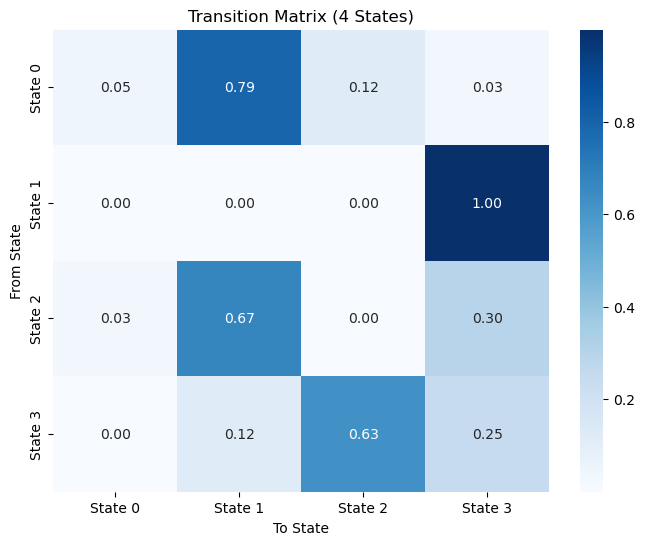

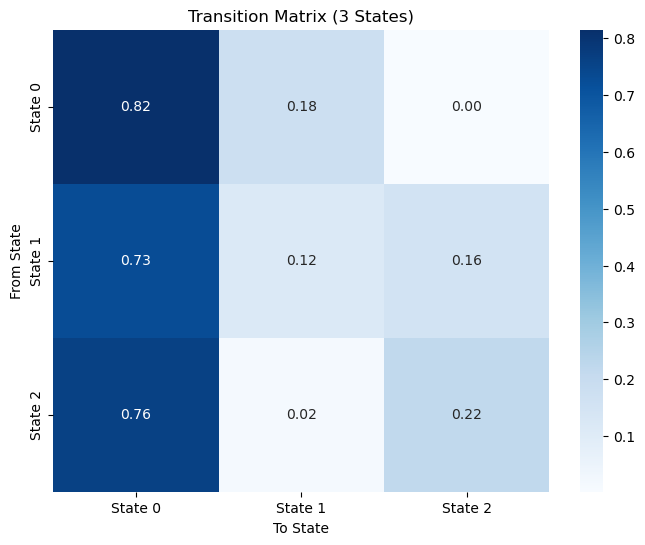

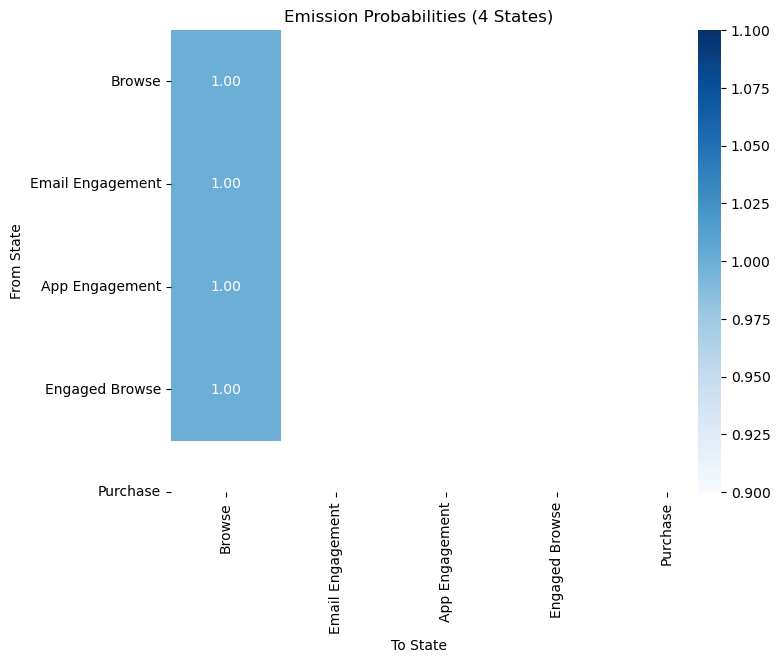

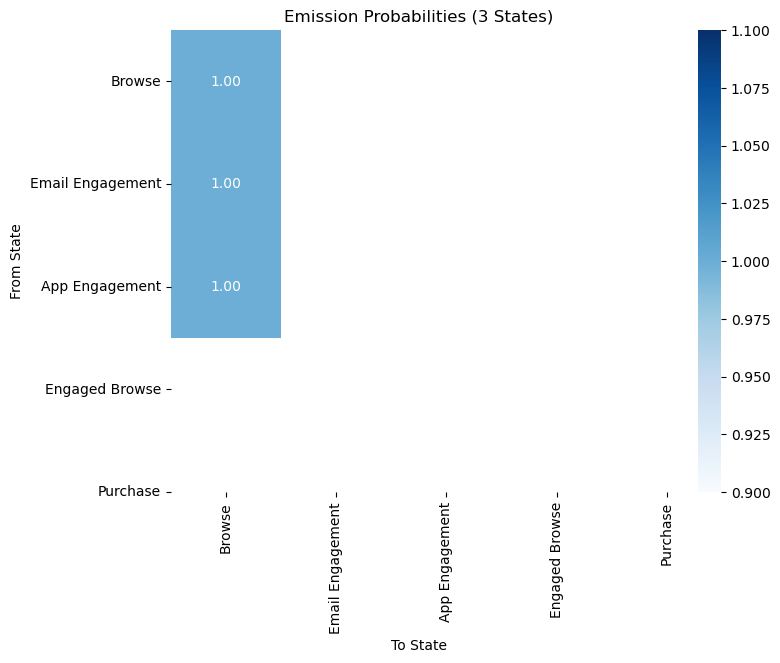

(array([[1.],
        [1.],
        [1.],
        [1.]]),
 array([[1.],
        [1.],
        [1.]]))

In [20]:
# =============================================
# Visualize the Hidden States
# =============================================

# Define the labels for observed actions
observed_labels = ["Browse", "Email Engagement", "App Engagement", "Engaged Browse", "Purchase"]

# Define and visualize the transition matrix and emission probabilities for the chosen HMM models

def plot_matrix(matrix, labels, title, cmap="Blues"):
    """Helper function to plot transition and emission matrices."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("To State")
    plt.ylabel("From State")
    plt.show()

# Plot transition matrices
plot_matrix(model_4.transmat_, ["State 0", "State 1", "State 2", "State 3"], "Transition Matrix (4 States)")
plot_matrix(model_3.transmat_, ["State 0", "State 1", "State 2"], "Transition Matrix (3 States)")
# This tells us how likely it is for a customer to move from one hidden state to another.

# Plot emission probabilities
plot_matrix(model_4.emissionprob_, observed_labels, "Emission Probabilities (4 States)")
plot_matrix(model_3.emissionprob_, observed_labels, "Emission Probabilities (3 States)")

# Extract the emission probabilities for interpretation
emission_probs_4 = model_4.emissionprob_
emission_probs_3 = model_3.emissionprob_
# This tells us what actions (browse, email engagement, app engagement, engaged browse, purchase) are most likely to be observed in each hidden state.

emission_probs_4, emission_probs_3


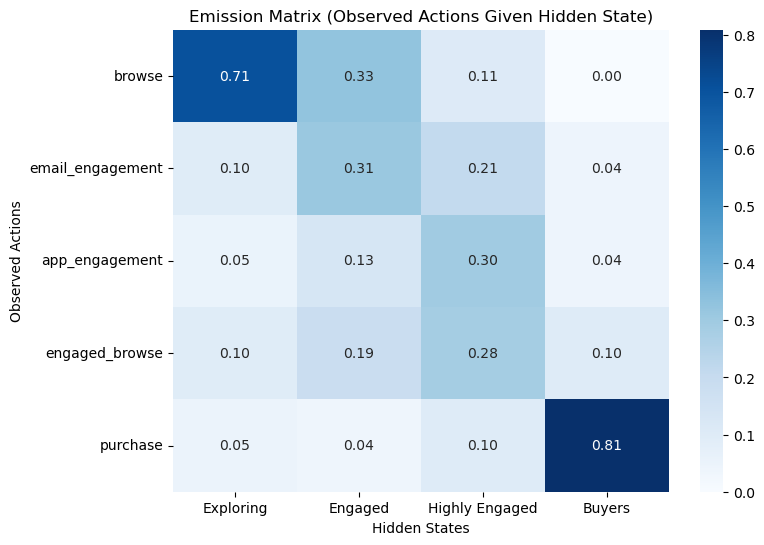

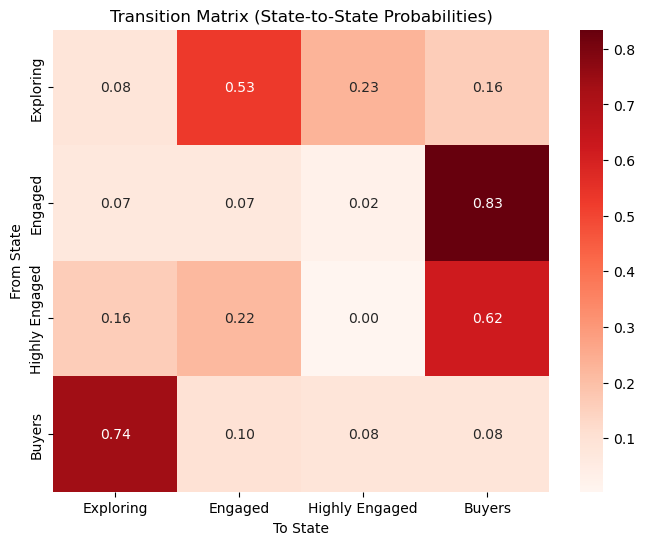

In [ ]:
# =============================================
# For the prebuilt Hidden States
# =============================================

# Define hidden states
hidden_states = ["Exploring", "Engaged", "Highly Engaged", "Buyers"]

# Define observed actions
observations = ["browse", "email_engagement", "app_engagement", "engaged_browse", "purchase"]

# Given action counts per hidden state
emission_counts = {
    "Exploring": {"browse": 1266, "email_engagement": 175, "app_engagement": 92, "engaged_browse": 172, "purchase": 90},
    "Engaged": {"browse": 302, "email_engagement": 289, "app_engagement": 124, "engaged_browse": 173, "purchase": 37},
    "Highly Engaged": {"browse": 62, "email_engagement": 122, "app_engagement": 171, "engaged_browse": 165, "purchase": 59},
    "Buyers": {"browse": 0, "email_engagement": 17, "app_engagement": 17, "engaged_browse": 40, "purchase": 313},
}

# Normalize emission matrix to get probabilities
emission_matrix = pd.DataFrame(emission_counts)
emission_matrix = emission_matrix.div(emission_matrix.sum(axis=0), axis=1)

# Generate random transition matrix (adjust if you have real transitions)
np.random.seed(42)
transition_matrix = pd.DataFrame(
    np.random.dirichlet(np.ones(len(hidden_states)), size=len(hidden_states)),
    index=hidden_states,
    columns=hidden_states
)

# Plot emission matrix
plt.figure(figsize=(8, 6))
sns.heatmap(emission_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Emission Matrix (Observed Actions Given Hidden State)")
plt.ylabel("Observed Actions")
plt.xlabel("Hidden States")
plt.show()

# Plot transition matrix
plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, cmap="Reds", fmt=".2f")
plt.title("Transition Matrix (State-to-State Probabilities)")
plt.ylabel("From State")
plt.xlabel("To State")
plt.show()


# Matrix overview
#                   Exploring   Engaged  Highly Engaged    Buyers
# browse             0.705292  0.326486        0.107081  0.000000
# email_engagement   0.097493  0.312432        0.210708  0.043928
# app_engagement     0.051253  0.134054        0.295337  0.043928
# engaged_browse     0.095822  0.187027        0.284974  0.103359
# purchase           0.050139  0.040000        0.101900  0.808786


#                 Exploring   Engaged  Highly Engaged    Buyers
# Exploring        0.082197  0.527252        0.230641  0.159911
# Engaged          0.070375  0.070363        0.024826  0.834435
# Highly Engaged   0.161962  0.216972        0.003665  0.617401
# Buyers           0.735638  0.098290        0.082638  0.083434
# Emission Matrix
# What This Tells Us
# Exploring: These users are overwhelmingly browsing (70.5%), with very little deep engagement. Some email engagement (9.7%) and engaged browsing (9.6%) occur, but purchasing is low (5.0%).
# Engaged: A more balanced mix of behaviors—32.6% still browsing, but 31.2% engaging via email, and more app engagement (13.4%). Purchases are still low (4.0%).
# Highly Engaged: These users have high app engagement (29.5%) and engaged browsing (28.5%), meaning they’re interacting deeply. Their purchase rate (10.2%) is still relatively low but increasing.
# Buyers: The majority of actions are purchases (80.9%). These users rarely browse (0.0%), meaning they likely go directly to buying.
# Key Takeaway:
# Customers generally move from browsing to more engaged behaviors before purchasing. Engaged browsing and app engagement seem to be strong indicators of an eventual purchase.

# What This Tells Us
# Exploring → Engaged (52.7%): Over half of users move from "Exploring" to "Engaged," meaning many users deepen their engagement after initial browsing.
# Engaged → Buyers (83.4%): Once users become engaged, a large portion of them (83.4%) proceed directly to purchase.
# Highly Engaged → Buyers (61.7%): Many users in this state purchase, but some still stay in this high-engagement state without converting.
# Buyers → Exploring (73.6%): A huge portion of buyers move back to "Exploring," likely meaning repeat customers re-enter the journey.
# Key Takeaway:

# The most reliable conversion path is Engaged → Buyers (83.4%).
# The Highly Engaged state is not necessarily required for a purchase but does increase engagement.
# Once a customer buys, they are very likely to return to the Exploring phase, possibly looking for new products.
